In [1]:
import CPU_code
import GPU_code
import numpy as np
import time
import cupy as cp 
import matplotlib.pyplot as plt

# Comparision at individuals lavel 

## CPU times


In [2]:
# CPU
data_dist_CPU = np.random.exponential(scale=1.0, size=1000)
t_inds = [10**i for i in range(1,7)]
hist, bin_edges = np.histogram(data_dist_CPU, bins=10, density=True)
ind_CPU = CPU_code.Individual(initial_position=[0,0],waiting_time_dist=[hist,bin_edges],step_size_dist=[hist,bin_edges])
exc_times_CPU = []
tryals= 50
for time_ in t_inds:
    sum_time=0
    for tryal in range(tryals):
        ini_time = time.time()
        ind_CPU.move(time=time_)
        end_time = time.time()
        sum_time += end_time - ini_time
    exc_times_CPU.append(sum_time/tryals)


In [3]:
exc_times_CPU = np.array(exc_times_CPU)
np.savetxt('CPU_times.txt',exc_times_CPU)

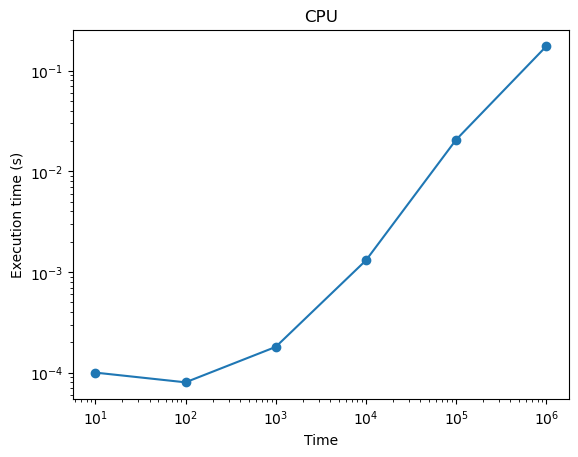

In [6]:
plt.plot(t_inds,exc_times_CPU,"-o")
plt.xlabel('Time')
plt.ylabel('Execution time (s)')
plt.title('CPU')
plt.xscale('log')
plt.yscale('log')
plt.show()


## GPU times

In [7]:
# GPU
data_dist_GPU = cp.random.exponential(scale=1.0, size=1000)
t_inds = [10**i for i in range(1,7)]
hist, bin_edges = cp.histogram(data_dist_GPU, bins=10, density=True)
ind_GPU = GPU_code.Individual(initial_position=[0,0],waiting_time_dist=[hist,bin_edges],step_size_dist=[hist,bin_edges])
exc_times_GPU = []
tryals= 50
for time_ in t_inds:
    sum_time=0
    for tryal in range(tryals):
        start_gpu = cp.cuda.Event()
        start_gpu.record()
        ind_GPU.move(time=time_)
        end_gpu = cp.cuda.Event()
        end_gpu.record()
        end_gpu.synchronize()
        t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
        sum_time += t_gpu
    exc_times_GPU.append(sum_time/tryals)


In [8]:
exc_time_GPU= np.array(exc_times_CPU)
np.savetxt('GPU_times.txt',exc_times_GPU)

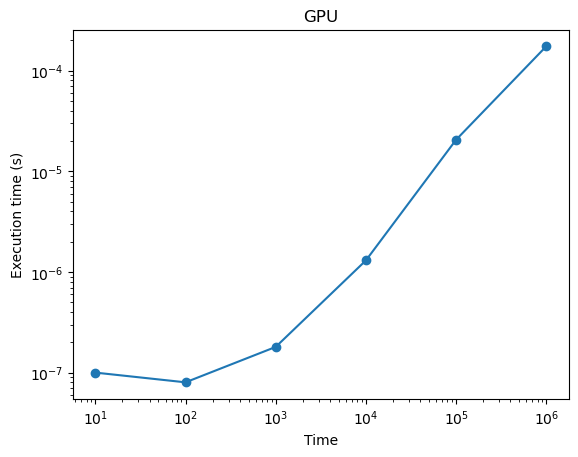

In [10]:
plt.plot(t_inds,exc_time_GPU/1000,"-o")
plt.xlabel('Time')
plt.ylabel('Execution time (s)')
plt.title('GPU')
plt.yscale('log')
plt.xscale('log')
plt.show()

# Comparition at ensamble level

CPU 

In [11]:
# Ensamble less time 
data_dist_CPU = np.random.exponential(scale=1.0, size=1000)
N_inds = [10**i for i in range(1,7)]
hist, bin_edges = np.histogram(data_dist_CPU, bins=10, density=True)
time_=60
ensamble_times_CPU = []
tryals= 50

for N_ind in N_inds:
    sum_time=0
    for tryal in range(tryals):
        initial_pos = np.zeros((N_ind,2))
        ensamble_CPU = CPU_code.Ensemble(N_ind,initial_positions=initial_pos ,waiting_time_dist=[hist,bin_edges],step_size_dist=[hist,bin_edges])
        ini_time = time.time()
        ensamble_CPU.move(time=time_)
        end_time = time.time()
        sum_time += end_time - ini_time
    ensamble_times_CPU.append(sum_time/tryals)


In [12]:
np.savetxt("ensamble_times_60min_CPU",np.array(ensamble_times_CPU))

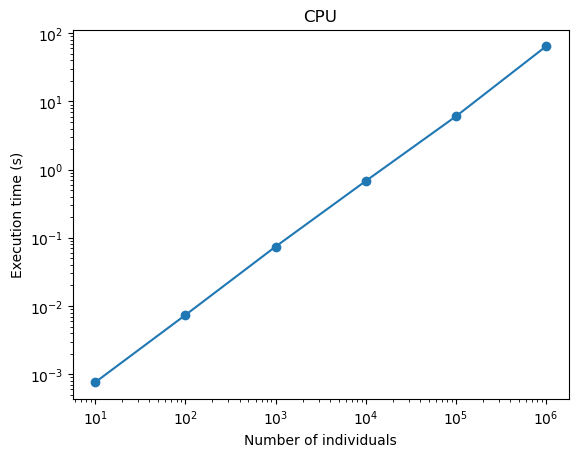

In [18]:
plt.plot([10**i for i in range(1,7)], ensamble_times_CPU, "-o")
plt.xlabel('Number of individuals')
plt.ylabel('Execution time (s)')
plt.title('CPU')
plt.yscale('log')
plt.xscale('log')
plt.show()


gpu

In [28]:
# CPU
data_dist_GPU = cp.random.exponential(scale=1.0, size=1000)
N_inds = [10**i for i in range(1,5)]
hist, bin_edges = cp.histogram(data_dist_GPU, bins=10, density=True)
time_=60
ensamble_times_GPU = []
tryals= 50

for N_ind in N_inds:
    sum_time=0
    for tryal in range(tryals):
        initial_pos = cp.zeros((N_ind,2))
        ensamble_GPU = GPU_code.Ensemble(N_ind,initial_positions=initial_pos ,waiting_time_dist=[hist,bin_edges],step_size_dist=[hist,bin_edges])
        start_gpu = cp.cuda.Event()
        start_gpu.record()
        ensamble_GPU.move(time=time_)
        end_gpu = cp.cuda.Event()
        end_gpu.record()
        end_gpu.synchronize()
        t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
        sum_time += t_gpu
    ensamble_times_GPU.append(sum_time/tryals)


In [24]:
np.savetxt("ensamble_times_60min_GPU",np.array(ensamble_times_GPU))
ensamble_GPU= np.array(ensamble_times_GPU)

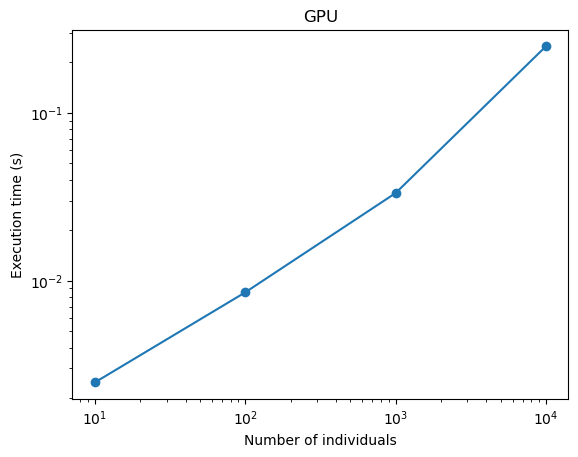

In [25]:
plt.plot(N_inds, ensamble_GPU/1000, "-o")
plt.xlabel('Number of individuals')
plt.ylabel('Execution time (s)')
plt.title('GPU')
plt.yscale('log')
plt.xscale('log')
plt.show()


Comparision at individuals lavel

In [29]:
CPU_times_ind = np.loadtxt("CPU_times.txt")
GPU_times_ind = np.loadtxt("GPU_times.txt")
CPU_times_ensamble = np.loadtxt("ensamble_times_60min_CPU")
GPU_times_ensamble = np.loadtxt("ensamble_times_60min_GPU")
ind_times = np.array([10**i for i in range(1,7)])
ensamble_times = np.array([10**i for i in range(1,5)])
CPU_times_ensamble= CPU_times_ensamble[:4]

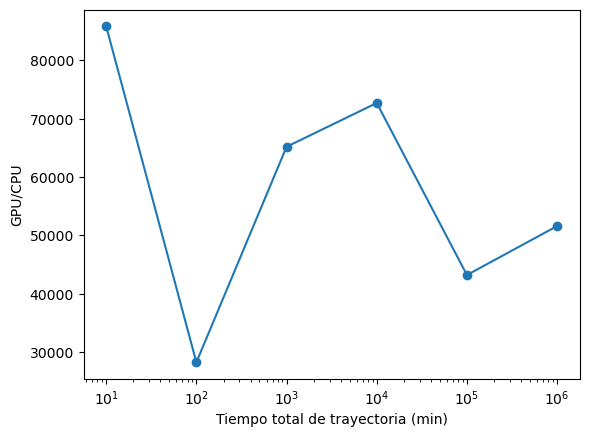

In [33]:
#ind level times GPU/times CPU 
plt.plot(ind_times, GPU_times_ind/CPU_times_ind, "-o")
plt.xlabel('Tiempo total de trayectoria (min)')
plt.ylabel('GPU/CPU')
plt.grid()
plt.xscale('log')
plt.show()


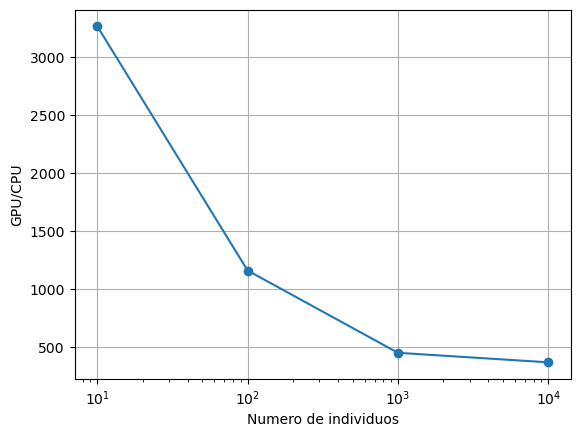

In [37]:
# ensamble level times GPU / times CPU 
plt.plot(ensamble_times, GPU_times_ensamble/CPU_times_ensamble, "-o")
plt.xlabel('Numero de individuos')
plt.ylabel('GPU/CPU')
plt.grid()
plt.xscale('log')
#plt.yscale('log')

plt.show()
